In [15]:
import pandas as pd

dataset = pd.read_csv("resume_screnning_data.csv")

print(dataset.head())

        id                                    resume_text_256  \
0  RS00000  8+ years experience; key skills: linux, contai...   
1  RS00001  0+ years experience; key skills: kafka, ci/cd,...   
2  RS00002  0+ years experience; key skills: bug-tracking,...   
3  RS00003  2+ years experience; key skills: test-cases, b...   
4  RS00004  9+ years experience; key skills: testing, bug-...   

                                         jd_text_128 job_family seniority  \
0  We are hiring a Senior DevOps professional. Mu...     DevOps    Senior   
1  We are hiring a Junior PM professional. Must h...         PM    Junior   
2  We are hiring a Junior QA professional. Must h...         QA    Junior   
3  We are hiring a Mid QA professional. Must have...         QA       Mid   
4  We are hiring a Senior QA professional. Must h...         QA    Senior   

   advance  
0        1  
1        0  
2        1  
3        1  
4        1  


In [16]:
dataset.shape

(2000, 6)

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2000 non-null   object
 1   resume_text_256  2000 non-null   object
 2   jd_text_128      2000 non-null   object
 3   job_family       2000 non-null   object
 4   seniority        2000 non-null   object
 5   advance          2000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 93.9+ KB


In [18]:
print(dataset.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 2000, dtype: bool


In [19]:
print(dataset.isnull().sum())

id                 0
resume_text_256    0
jd_text_128        0
job_family         0
seniority          0
advance            0
dtype: int64


In [20]:
dataset = dataset.drop('id', errors='ignore')
dataset.columns

Index(['id', 'resume_text_256', 'jd_text_128', 'job_family', 'seniority',
       'advance'],
      dtype='object')

In [21]:
from sklearn.preprocessing import LabelEncoder

job_encoder = LabelEncoder()
seniority_encoder = LabelEncoder()
dataset['job_family2'] = dataset['job_family']
dataset['job_family'] = job_encoder.fit_transform(dataset['job_family'])
dataset['seniority'] = seniority_encoder.fit_transform(dataset['seniority'])
print(dataset.head())

        id                                    resume_text_256  \
0  RS00000  8+ years experience; key skills: linux, contai...   
1  RS00001  0+ years experience; key skills: kafka, ci/cd,...   
2  RS00002  0+ years experience; key skills: bug-tracking,...   
3  RS00003  2+ years experience; key skills: test-cases, b...   
4  RS00004  9+ years experience; key skills: testing, bug-...   

                                         jd_text_128  job_family  seniority  \
0  We are hiring a Senior DevOps professional. Mu...           2          2   
1  We are hiring a Junior PM professional. Must h...           4          0   
2  We are hiring a Junior QA professional. Must h...           5          0   
3  We are hiring a Mid QA professional. Must have...           5          1   
4  We are hiring a Senior QA professional. Must h...           5          2   

   advance job_family2  
0        1      DevOps  
1        0          PM  
2        1          QA  
3        1          QA  
4        

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


resume_tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
resume_tokenizer.fit_on_texts(dataset['resume_text_256'])
resume_sequences = resume_tokenizer.texts_to_sequences(dataset['resume_text_256'])
resume_padded = pad_sequences(resume_sequences)

jd_tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
jd_tokenizer.fit_on_texts(dataset['jd_text_128'])
jd_sequences = jd_tokenizer.texts_to_sequences(dataset['jd_text_128'])
jd_padded = pad_sequences(jd_sequences)
print(resume_padded)


[[ 0  0  0 ... 13  2 14]
 [ 0  0  0 ... 13  2 14]
 [ 0  0  0 ... 13  2 14]
 ...
 [ 0  0  0 ... 13  2 15]
 [ 0  0  0 ... 13  2 17]
 [ 0  0  0 ... 13  2 17]]


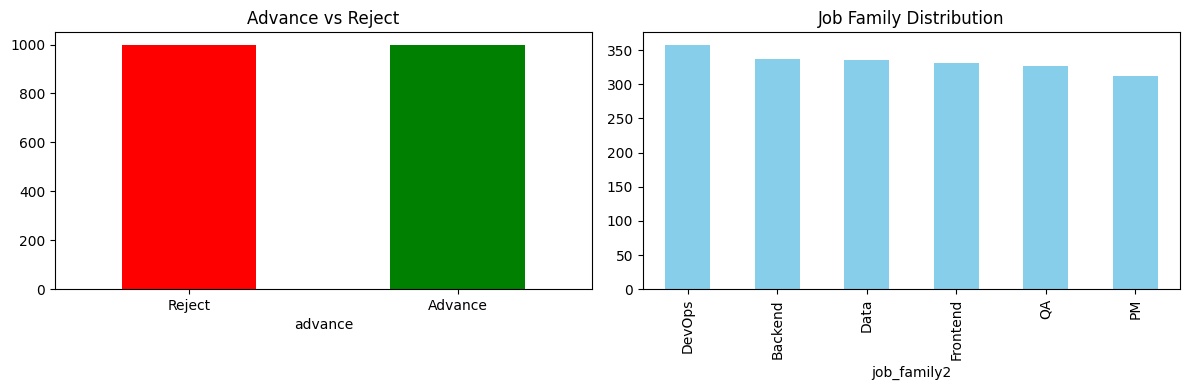

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

dataset['advance'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Advance vs Reject')
axes[0].set_xticklabels(['Reject', 'Advance'], rotation=0)

dataset['job_family2'].value_counts().plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Job Family Distribution')

plt.tight_layout()
plt.show()

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

X_job_family = dataset['job_family'].values.reshape(-1, 1)
X_seniority = dataset['seniority'].values.reshape(-1, 1)
y = dataset['advance'].values

indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y)

resume_padded_train, resume_padded_test = resume_padded[train_idx], resume_padded[test_idx]
X_jd_train, X_jd_test = jd_padded[train_idx], jd_padded[test_idx]
X_job_family_train, X_job_family_test = X_job_family[train_idx], X_job_family[test_idx]
X_seniority_train, X_seniority_test = X_seniority[train_idx], X_seniority[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

combined_train = np.concatenate([
    resume_padded_train,
    X_jd_train,
    X_job_family_train,
    X_seniority_train
], axis=1)

combined_test = np.concatenate([
    resume_padded_test,
    X_jd_test,
    X_job_family_test,
    X_seniority_test
], axis=1)


model = Sequential([
    Dense(256, activation='relu', input_shape=(combined_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\legende\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    combined_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5781 - loss: 2.3467 - val_accuracy: 0.7063 - val_loss: 0.5802
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6523 - loss: 0.6210 - val_accuracy: 0.7375 - val_loss: 0.5119
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6687 - loss: 0.5883 - val_accuracy: 0.7969 - val_loss: 0.4821
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7094 - loss: 0.5669 - val_accuracy: 0.7250 - val_loss: 0.5178
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6766 - loss: 0.5745 - val_accuracy: 0.6469 - val_loss: 0.5332
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6922 - loss: 0.5567 - val_accuracy: 0.7781 - val_loss: 0.4838
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7164 - loss: 0.5090 - val_accuracy: 0.7781 - val_loss: 0.4494
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6992 - loss: 0.5284 - val_accuracy: 0.7406 - val_loss:

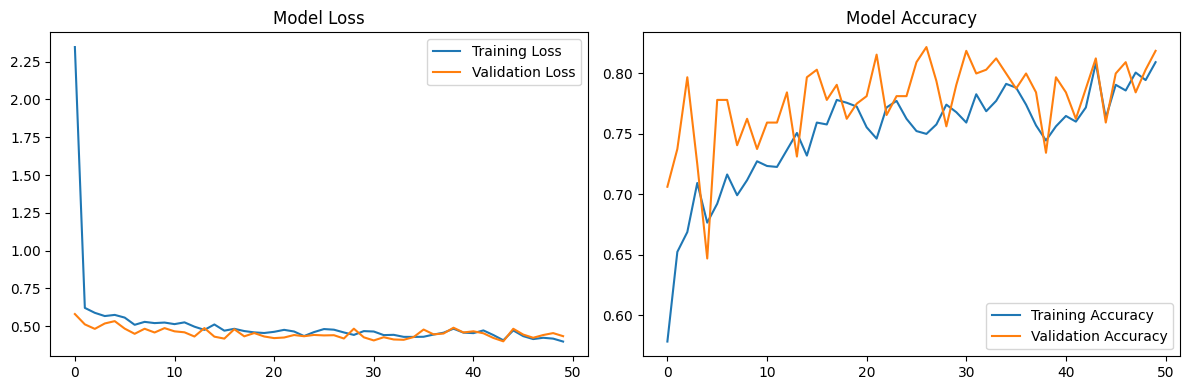

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
import pickle
with open("resume_screnning.pkl", "wb") as file:
    pickle.dump(model, file)